In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import spacy
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

In [2]:
df = pd.read_csv("../data/nlp_data_scientist_challenge_dataset.csv")
df['is_consultancy']= df['is_consultancy'].astype('int')

In [3]:
df.head()

,company_id,group_id,is_consultancy,predicted_consultancy,text
0,d2d78cb1fe31d2c8fb7cc84bb1cab3ef,654,0,0.0,Legal Disclaimer MICRO-ALGAE PRODUCTION FACILI...
1,defd325d9bfa59e9843c23da0b0c2d8c,414,0,0.0,Home What We Do Technology Products EktoTherix...
2,a29dda8947c86bd7206137744fa201ef,414,0,0.0,top of page HOME ABOUT ADVISORS NEWSLETTER IMP...
3,e99d0615faa5a5405519c3c5dedc24ab,521,1,0.0,Skip to content Ayruz Data Marketing: Data Dri...
4,ee1951864f9ed6812b5350ccb04ef83b,654,0,0.0,top of page HOME OUR STORY PRODUCTS SUPERPLANT...


In [4]:
# Group by the 'group_id' column and count the number of rows in each group
grouped = df.groupby('group_id').size()

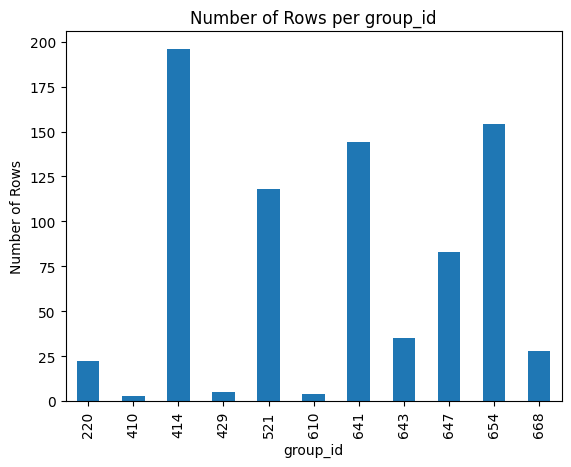

In [5]:
# Plot the results
grouped.plot(kind='bar', xlabel='group_id', ylabel='Number of Rows', title='Number of Rows per group_id')
plt.show()

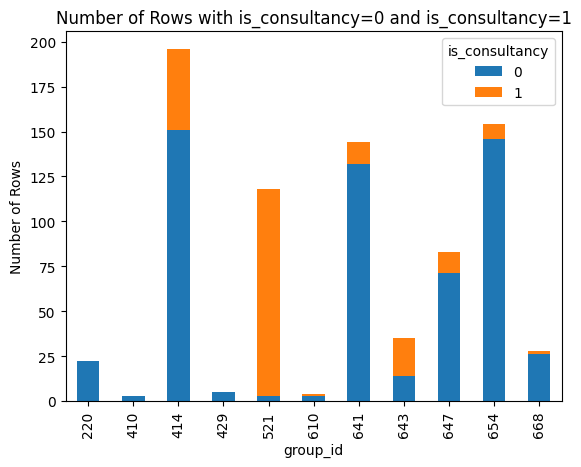

In [6]:
# Group by the 'Category' column and count the number of rows with 't' values 0 and 1 in each group
grouped = df.groupby(['group_id', 'is_consultancy']).size().unstack(fill_value=0)

# Plot the results
grouped.plot(kind='bar', stacked=True, xlabel='group_id', ylabel='Number of Rows', title='Number of Rows with is_consultancy=0 and is_consultancy=1')
plt.legend(title='is_consultancy')
plt.show()

### Confusion matrix and preformance metrics of the model already existing

The shape of orginal dataframe: (792, 5) and modified dataframe is:  (775, 5)


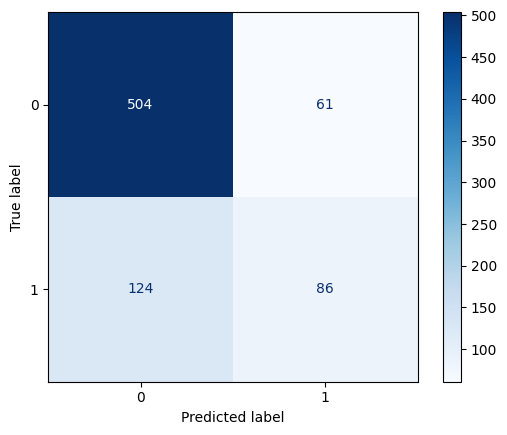

In [7]:
# remove the rows without prediction from already existing model
df_mod = df.dropna(subset=['predicted_consultancy'])
print("The shape of orginal dataframe:", df.shape, "and modified dataframe is: ", df_mod.shape)
cm = confusion_matrix(df_mod['is_consultancy'], df_mod['predicted_consultancy'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [8]:
report=classification_report(df_mod['is_consultancy'], df_mod['predicted_consultancy'])
print(report)

              precision    recall  f1-score   support

           0       0.80      0.89      0.84       565
           1       0.59      0.41      0.48       210

    accuracy                           0.76       775
   macro avg       0.69      0.65      0.66       775
weighted avg       0.74      0.76      0.75       775



## Now cleaning the text using spacy model and get the vectorized version of "text" column

In [9]:
# Load a spaCy model for text preprocessing
nlp = spacy.load("en_core_web_sm")

# Define a function to preprocess text using spaCy
def preprocess_text(text):
    doc = nlp(text)
    # Tokenize, lemmatize, and remove stopwords
    tokens = [token.lemma_ for token in doc if not token.is_stop]
    return ' '.join(tokens)

# Apply the text preprocessing function to the "text" column
df['cleaned_text'] = df['text'].apply(preprocess_text)

# Create a TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer()

# Fit and transform the cleaned text data into TF-IDF vectors
tfidf_vectors = tfidf_vectorizer.fit_transform(df['cleaned_text'])

# Convert the TF-IDF vectors into a DataFrame for better visualization
tfidf_df = pd.DataFrame(tfidf_vectors.toarray(), columns=tfidf_vectorizer.get_feature_names_out())

# Print the TF-IDF DataFrame
print(tfidf_df)

      00       000  0000  0001  000ft2home  000x  001     00100  00146  003  \
0    0.0  0.025326   0.0   0.0         0.0   0.0  0.0  0.000000    0.0  0.0   
1    0.0  0.000000   0.0   0.0         0.0   0.0  0.0  0.000000    0.0  0.0   
2    0.0  0.000000   0.0   0.0         0.0   0.0  0.0  0.000000    0.0  0.0   
3    0.0  0.000000   0.0   0.0         0.0   0.0  0.0  0.000000    0.0  0.0   
4    0.0  0.000000   0.0   0.0         0.0   0.0  0.0  0.000000    0.0  0.0   
..   ...       ...   ...   ...         ...   ...  ...       ...    ...  ...   
787  0.0  0.000000   0.0   0.0         0.0   0.0  0.0  0.000000    0.0  0.0   
788  0.0  0.000000   0.0   0.0         0.0   0.0  0.0  0.000000    0.0  0.0   
789  0.0  0.000000   0.0   0.0         0.0   0.0  0.0  0.000000    0.0  0.0   
790  0.0  0.000000   0.0   0.0         0.0   0.0  0.0  0.000000    0.0  0.0   
791  0.0  0.000000   0.0   0.0         0.0   0.0  0.0  0.146897    0.0  0.0   

     ...  übertragung  überwachung  ühingujuhtimise

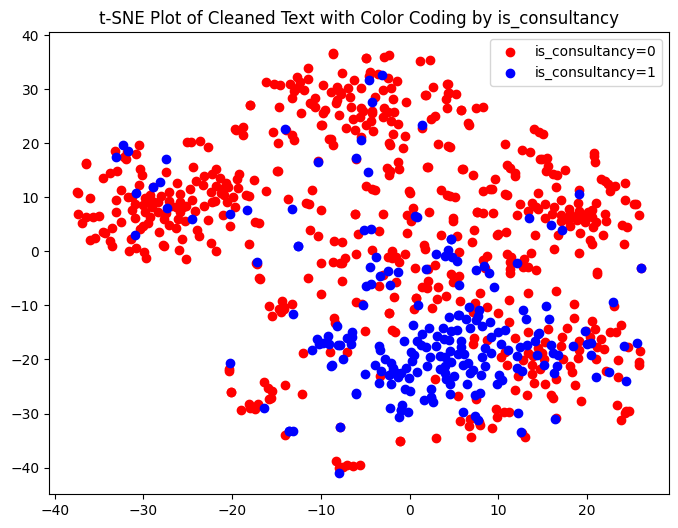

In [10]:
# Initialize t-SNE model
tsne = TSNE(n_components=2, random_state=0)

# Fit and transform the TF-IDF vectors using t-SNE
tsne_result = tsne.fit_transform(tfidf_vectors.toarray())

# Add the t-SNE results to the DataFrame
df['tsne_x'] = tsne_result[:, 0]
df['tsne_y'] = tsne_result[:, 1]

# Plot the t-SNE plot and color code it by "is_consultancy"
plt.figure(figsize=(8, 6))
colors = {0: 'red', 1: 'blue'}
for is_consultancy, color in colors.items():
    subset = df[df['is_consultancy'] == is_consultancy]
    plt.scatter(subset['tsne_x'], subset['tsne_y'], c=color, label=f'is_consultancy={is_consultancy}')

plt.title('t-SNE Plot of Cleaned Text with Color Coding by is_consultancy')
plt.legend()
plt.show()

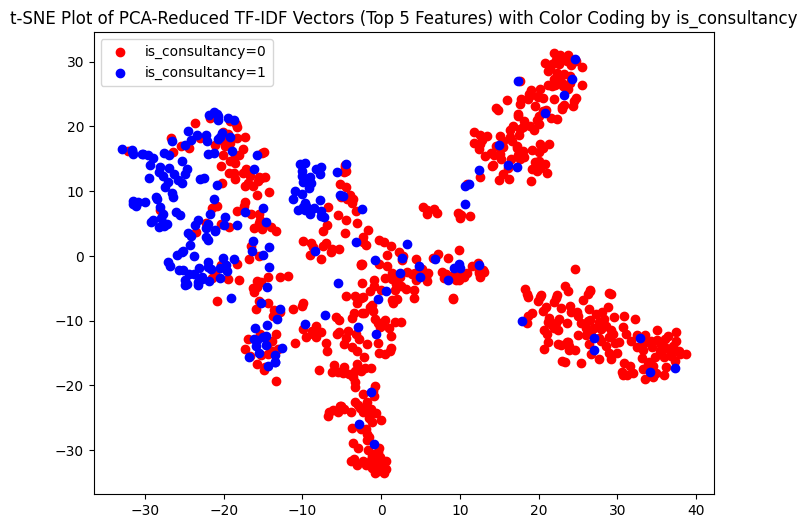

In [11]:
# Apply PCA to reduce the dimensionality to the top 25 features
pca = PCA(n_components=8)
tfidf_vectors_pca = pca.fit_transform(tfidf_vectors.toarray())

# Initialize t-SNE model
tsne = TSNE(n_components=2, random_state=0)

# Fit and transform the PCA-reduced TF-IDF vectors using t-SNE
tsne_result = tsne.fit_transform(tfidf_vectors_pca)

# Add the t-SNE results to the DataFrame
df['tsne_x'] = tsne_result[:, 0]
df['tsne_y'] = tsne_result[:, 1]

# Plot the t-SNE plot and color code it by "is_consultancy"
plt.figure(figsize=(8, 6))
colors = {0: 'red', 1: 'blue'}
for is_consultancy, color in colors.items():
    subset = df[df['is_consultancy'] == is_consultancy]
    plt.scatter(subset['tsne_x'], subset['tsne_y'], c=color, label=f'is_consultancy={is_consultancy}')

plt.title('t-SNE Plot of PCA-Reduced TF-IDF Vectors (Top 5 Features) with Color Coding by is_consultancy')
plt.legend()
plt.show()

### Given the above analysis, a model will be trained and the steps are explained in Readme